In [2]:
%load_ext sagemaker_studio_analytics_extension.magics
%sm_analytics emr connect --verify-certificate False --cluster-id j-2JXH5IL8O66AE --auth-type None --language python  

Successfully read emr cluster(j-2JXH5IL8O66AE) details
Initiating EMR connection..
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1729541492670_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.
{"namespace": "sagemaker-analytics", "cluster_id": "j-2JXH5IL8O66AE", "error_message": null, "success": true, "service": "emr", "operation": "connect"}


# Connection Requirement:
- Start local instance with image SparkAnalytics 3.0 and Kernel SparkMagic Pyspark
- Start one EMR cluster
- Connect EMR cluster to the notebook instance

## 1. Reading Data from DataLake

In [4]:

import sys

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

session_name = 'pltv_v2_gclid'
database = 'ml_revenue_relevance_pltv_cln_local'
table = 'pltv_v2_model_gclid_daily_cln'

spark = (
        SparkSession.builder.appName(session_name)
        .config("hive.exec.dynamic.partition.mode", "nonstrict")
        .config("hive.exec.dynamic.partition", "true")
        .config("spark.sql.sources.partitionOverwriteMode", "dynamic")
        .enableHiveSupport()
        .getOrCreate()
    )
pltv_part = spark.sql("""show partitions ml_revenue_relevance_pltv_cln.pltv_v2_model_weekly_cln""")
pltv_part.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|           partition|
+--------------------+
|year=2020/month=1...|
|year=2020/month=1...|
|year=2020/month=1...|
|year=2020/month=1...|
|year=2020/month=2...|
+--------------------+
only showing top 5 rows

In [9]:
%%sh
aws s3 ls s3://gd-revrelvnc-stage-pltv2/prod_doc/

                           PRE prod_model/
2022-11-04 23:12:15          0 
2023-01-27 04:44:34      75043 pltv_features-temp.csv
2023-09-07 19:32:04      78709 pltv_features.csv
2023-09-07 19:31:55      78709 pltv_features2.csv


## 2. Reading Data from S3

In [5]:
data = [('James','','Smith','1991-04-01','M',3000), 
        ('Michael','Rose','','2000-05-19','M',4000),
        ('Robert','','Williams','1978-09-05','M',4000),
        ('Maria','Anne','Jones','1967-12-01','F',4000),
        ('Jen','Mary','Brown','1980-02-17','F',-1)
]

columns = ["firstname","middlename","lastname","dob","gender","salary"]
df = spark.createDataFrame(data=data, schema = columns)
df.createOrReplaceTempView('emp_view')
df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+--------+----------+------+------+
|firstname|middlename|lastname|       dob|gender|salary|
+---------+----------+--------+----------+------+------+
|    James|          |   Smith|1991-04-01|     M|  3000|
|  Michael|      Rose|        |2000-05-19|     M|  4000|
|   Robert|          |Williams|1978-09-05|     M|  4000|
|    Maria|      Anne|   Jones|1967-12-01|     F|  4000|
|      Jen|      Mary|   Brown|1980-02-17|     F|    -1|
+---------+----------+--------+----------+------+------+

In [6]:
%%sql
select * from emp_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [7]:
s3_path= "s3://gd-revrelvnc-stage-pltv2/table/f2p_combine_features/customer_type=nru/local_date=2020-04-01/"
s3_stage = "s3://gd-revrelvnc-stage-pltv2/table/f2p_combine_features/"
df = spark.read.parquet(s3_path)
df.select(['id', 'if_shopper', 'sample', 'weight', 'is_visit_flag', 'is_order_flag']).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+------+------+-------------+-------------+
|       id|if_shopper|sample|weight|is_visit_flag|is_order_flag|
+---------+----------+------+------+-------------+-------------+
|140374629|         1|     1|   1.0|            0|            0|
|222198742|         1|     1|   1.0|            0|            0|
|208384690|         1|     1|   1.0|            0|            0|
|207042004|         1|     1|   1.0|            0|            0|
|224714725|         1|     1|   1.0|            0|            0|
|174253786|         1|     1|   1.0|            0|            0|
|254810672|         1|     1|   1.0|            0|            0|
|155481835|         1|     1|   1.0|            0|            0|
|174062490|         1|     1|   1.0|            0|            0|
|246895573|         1|     1|   1.0|            0|            0|
+---------+----------+------+------+-------------+-------------+
only showing top 10 rows

In [8]:
df.select(['id', 'if_shopper', 'sample', 'weight', 'is_visit_flag', 'is_order_flag']).write.mode('overwrite').parquet('s3://gd-revrelvnc-stage-pltv2/p2p_model/test3/')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Connect S3 with boto3

In [10]:
sc.install_pypi_package("numpy")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
import boto3
import re
import numpy as np
import os

def get_config_file_name(s3_path, end_date=None):
    s3 = boto3.resource('s3', region_name = 'us-west-2') 
    glue_bucket = s3.Bucket(s3_path.replace("s3://","").split("/")[0])
    folder_path = s3_path.split("/", 3)[3]

    objects = glue_bucket.objects.filter(Prefix=folder_path).all()
    dates_list = []
    for my_bucket_object in objects:
        print(my_bucket_object.key)
        dates_list.append(re.search(r"\d{4}-\d{2}-\d{2}", my_bucket_object.key).group(0))

    created_dates_list = [str(d) for d in np.unique(np.array(dates_list))]
    if end_date is not None:
        created_dates_list = [file for file in created_dates_list if file <= end_date]
        created_dates_list.sort()
    return created_dates_list[-1]

get_config_file_name('s3://gd-revrelvnc-stage-pltv2/pltv_model/pltv_adjust_model_v6/config/train_config/')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pltv_model/pltv_adjust_model_v6/config/train_config/2022-09-01/normalizer.pkl
pltv_model/pltv_adjust_model_v6/config/train_config/2022-09-01/train_config.yaml
'2022-09-01'

## Saving data to connected EMR local

In [13]:
sc.install_pypi_package("pandas")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1729541492670_0003/container_1729541492670_0003_01_000001/tmp/spark-4eb52116-603f-4c23-8acc-90e046f59594
    Can't uninstall 'python-dateutil'. No files were found to uninstall.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 2.15.30 requires python-dateutil<=2.8.2,>=2.1, but you have python-dateutil 2.9.0.post0 which is incompatible.

In [14]:
import pandas as pd

# Create a sample dataframe
Biodata = {'Name': ['John', 'Emily', 'Mike', 'Lisa'],
        'Age': [28, 23, 35, 31],
        'Gender': ['M', 'F', 'M', 'F']
        }
df = pd.DataFrame(Biodata)

# Save the dataframe to a CSV file
df.to_csv('./Biodata.csv', index=False)
#df.to_csv('/hodoop/opt/Biodata.csv', index=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
import yaml

data = dict(
    A = 'a',
    B = dict(
        C = 'c',
        D = 'd',
        E = 'e',
    )
)

with open('./data.yml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
import yaml
with open('data.yml', 'r') as file:
    prime_service = yaml.safe_load(file)
prime_service

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'A': 'a', 'B': {'C': 'c', 'D': 'd', 'E': 'e'}}

In [17]:
import subprocess

# Run the command and capture the output
output = subprocess.check_output("ls", shell=True)
print(output.decode("utf-8"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Biodata.csv
__spark_conf__
__spark_libs__
commons-codec-1.9.jar
container_tokens
data.yml
default_container_executor.sh
default_container_executor_session.sh
hive-site.xml
hudi-defaults.conf
kryo-shaded-4.0.2.jar
launch_container.sh
livy-api-0.8.0-incubating.jar
livy-core_2.12-0.8.0-incubating.jar
livy-repl_2.12-0.8.0-incubating.jar
livy-rsc-0.8.0-incubating.jar
livy-thriftserver-session-0.8.0-incubating.jar
minlog-1.3.0.jar
netty-all-4.1.100.Final.jar
netty-buffer-4.1.100.Final.jar
netty-codec-4.1.100.Final.jar
netty-codec-dns-4.1.100.Final.jar
netty-codec-haproxy-4.1.100.Final.jar
netty-codec-http-4.1.100.Final.jar
netty-codec-http2-4.1.100.Final.jar
netty-codec-memcache-4.1.100.Final.jar
netty-codec-mqtt-4.1.100.Final.jar
netty-codec-redis-4.1.100.Final.jar
netty-codec-smtp-4.1.100.Final.jar
netty-codec-socks-4.1.100.Final.jar
netty-codec-stomp-4.1.100.Final.jar
netty-codec-xml-4.1.100.Final.jar
netty-common-4.1.100.Final.jar
netty-handler-4.1.100.Final.jar
netty-handler-proxy-4.1.1

In [18]:
import boto3
from email import encoders
from email.mime.base import MIMEBase
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


def send_email(
    to_addr,
    from_addr="pltv_report@rnr.gdcorp.tools",
    subject="PLTV Report",
    body="",
    html_body_flag=False,
    file_list=None,
):
    """Function to send email using BOTO SES

    Args:
        to_addr (list): To email address
        from_addr (str): From email address
        subject (str): Subject line for the email
        body (str): Email body
        html_body_flag (boolean): indicates if the body is html string or plain text
        file_list (list): path to List of email attachments

    Returns:
        str: Boto SES request ID
    """
    # Create message container
    msg = MIMEMultipart("alternative")
    msg["subject"] = subject
    msg["To"] = to_addr
    msg["From"] = from_addr
    msg.preamble = """
        Your mail reader does not support the report format.
    """

    # Attach Email Body
    if html_body_flag:
        body = MIMEText(body, "html")
    else:
        body = MIMEText(body)
    msg.attach(body)

    # Embed html cid
    if file_list:
        for filename in file_list:
            with open(filename, "rb") as attachment:
                part = MIMEApplication(attachment.read())
                part.add_header(
                    "Content-Disposition", "attachment", filename=filename
                )
                msg.attach(part)
            attachment.close()
    # Convert message to string and send
    ses_client = boto3.client("ses", region_name="us-west-2")
    response = ses_client.send_raw_email(
        Source=msg["From"],
        Destinations=[msg["To"]],
        RawMessage={"Data": msg.as_string()}
    )
    print(response)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%%sh
aws s3 ls s3://gd-revrelvnc-stage-pltv2/table/f2p_combine_features/customer_type=nru/local_date=2020-01-01/

                           PRE task=infer/


In [20]:
data = [('James','','Smith','1991-04-01','M',3000), 
        ('Michael','Rose','','2000-05-19','M',4000),
        ('Robert','','Williams','1978-09-05','M',4000),
        ('Maria','Anne','Jones','1967-12-01','F',4000),
        ('Jen','Mary','Brown','1980-02-17','F',-1)
]

columns = ["firstname","middlename","lastname","dob","gender","salary"]
df = spark.createDataFrame(data=data, schema = columns).toPandas()
df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  firstname middlename  lastname         dob gender  salary
0     James                Smith  1991-04-01      M    3000
1   Michael       Rose            2000-05-19      M    4000
2    Robert             Williams  1978-09-05      M    4000
3     Maria       Anne     Jones  1967-12-01      F    4000
4       Jen       Mary     Brown  1980-02-17      F      -1

In [21]:
df_html = df.to_html()
subject = "pltv_report"
from_addr = "test_report@rnr.gdcorp.tools"
to_addr = "jli1@godaddy.com" 
file_list = []
send_email(to_addr, from_addr, subject, body=df_html, html_body_flag=True, file_list=file_list)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'MessageId': '01010192b14205fb-c72e2014-f581-4f57-82aa-86f6e31dcae8-000000', 'ResponseMetadata': {'RequestId': '76af6400-8fd5-4ead-83d4-2b20a8bfd039', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 21 Oct 2024 22:45:47 GMT', 'content-type': 'text/xml', 'content-length': '338', 'connection': 'keep-alive', 'x-amzn-requestid': '76af6400-8fd5-4ead-83d4-2b20a8bfd039'}, 'RetryAttempts': 0}}

In [22]:
%%sh
aws s3 ls

2024-05-24 17:16:51 cdk-cldinfra-assets-128519002737-us-west-2
2024-10-21 16:33:52 gd-access-revrelvnc-stage-logs-us-west-2
2024-10-21 16:31:22 gd-infra-logging-128519002737-us-west-2
2024-09-09 20:19:07 gd-revrelvnc-stage-applications
2024-09-09 20:19:07 gd-revrelvnc-stage-athena-results
2024-09-09 22:55:08 gd-revrelvnc-stage-backup
2022-05-18 16:23:05 gd-revrelvnc-stage-cdk-assets
2024-09-09 22:44:26 gd-revrelvnc-stage-cross-sell
2024-09-09 20:18:54 gd-revrelvnc-stage-data-lake
2024-09-21 04:50:50 gd-revrelvnc-stage-dnai-social-post-api
2024-10-21 16:33:52 gd-revrelvnc-stage-logging-us-west-2
2024-06-26 15:58:41 gd-revrelvnc-stage-mlflow
2024-09-09 21:40:22 gd-revrelvnc-stage-mmm-data
2023-12-12 20:23:58 gd-revrelvnc-stage-phd-events-us-west-2
2024-09-09 20:25:05 gd-revrelvnc-stage-pltv2
2024-09-09 21:33:06 gd-revrelvnc-stage-pricing
2023-10-18 21:46:09 gd-revrelvnc-stage-sem-bidding
2024-09-09 20:19:08 gd-revrelvnc-stage-success
2024-10-21 16:31:17 gd-server-access-revrelvnc-stage-u

## 4. test send to spark

In [43]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.
send_to_spark,%%send_to_spark -i variable -t str -n var,"Sends a variable from local output to spark cluster. Parameters: -i VAR_NAME: Local Pandas DataFrame(or String) of name VAR_NAME will be available in the %%spark context as a Spark dataframe(or String) with the same name. -t TYPE: Specifies the type of variable passed as -i. Available options are: `str` for string and `df` for Pandas DataFrame. Optional, defaults to `str`. -n NAME: Custom name of variable passed as -i. Optional, defaults to -i variable name. -m MAXROWS: Maximum amount of Pandas rows that will be sent to Spark. Defaults to 2500."
pretty,%%pretty,"If the cell output is a dataframe, like df.show(), then it will pretty print the dataframe as an HTML table"


In [44]:
%%local
local_var = "This variable exists on Studio Notebook kernel"

In [45]:
%%local
local_var

'This variable exists on Studio Notebook kernel'

In [46]:
%%local
ls

2.demo_emr.ipynb     redshift.ipynb                        summary_demo.ipynb
Pyspark_local.ipynb  redshift_nc.sql
athena_v2_nc.sql     summary_demo-studio-create-emr.ipynb


In [47]:
%%send_to_spark -i local_var  -t str -n var_on_cluster

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'local_var' as 'var_on_cluster' to Spark kernel

In [48]:
var_on_cluster

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'This variable exists on Studio Notebook kernel'

## 5. Visualization 

In [24]:
%%local
import plotly.express as px
gapminder = px.data.gapminder()
gapminder2007 = gapminder.query('year == 2007')
gapminder2007.head()

/opt/conda/envs/sm_sparkmagic/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning:

A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3



Output()

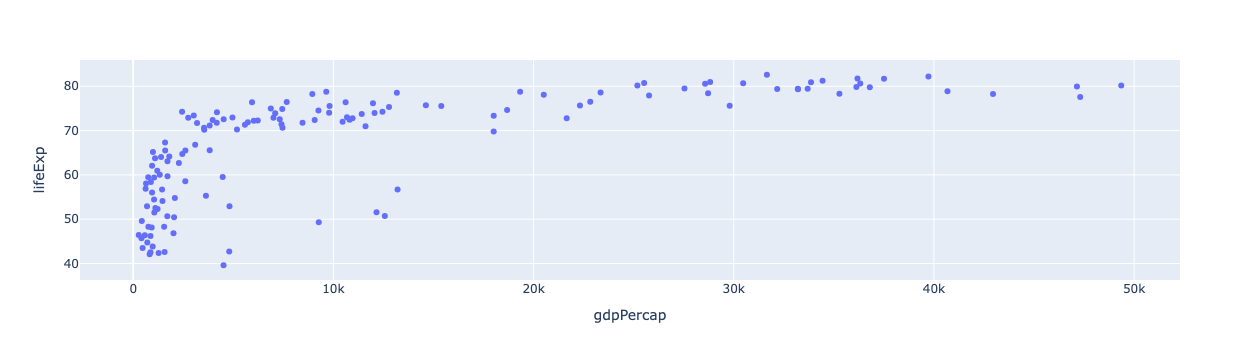

In [25]:
%%local
px.scatter(gapminder2007, x='gdpPercap', y='lifeExp')

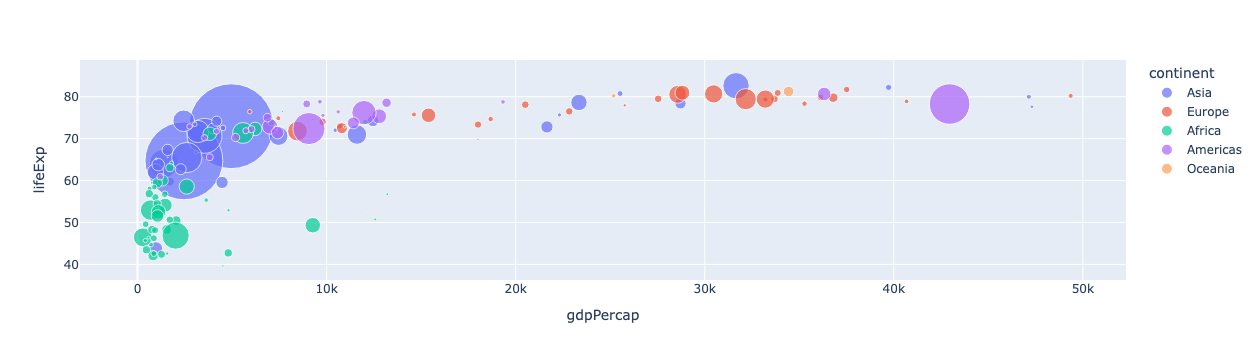

In [26]:
%%local
px.scatter(gapminder2007, x='gdpPercap', y='lifeExp',
          color='continent', size='pop', size_max=60)

## 6. Local tasks

In [42]:
%%local
import sys
import sagemaker
from sagemaker import get_execution_role
import boto3
s3_module_path = "s3://gd-revrelvnc-stage-pltv2/repo/monitor/src"
# save to local
sagemaker.s3.S3Downloader.download(s3_module_path, 'local_path')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


['local_path/__init__.py',
 'local_path/ab_test/aa_experiment.py',
 'local_path/ab_test/ab_experiment.py',
 'local_path/ab_test/stats_test.py',
 'local_path/common/__init__.py',
 'local_path/common/combine_f2p_p2p.py',
 'local_path/common/dq_check/base.py',
 'local_path/common/dq_check/categorical_features.py',
 'local_path/common/dq_check/dq_check.py',
 'local_path/common/dq_check/numerical_features.py',
 'local_path/common/dq_check/plot.py',
 'local_path/common/email_utils.py',
 'local_path/common/features.py',
 'local_path/common/features_spark.py',
 'local_path/common/html_templates/__init__.py',
 'local_path/common/html_templates/layout.html',
 'local_path/common/html_templates/template.html',
 'local_path/common/html_utils.py',
 'local_path/common/inference.py',
 'local_path/common/inference_spark.py',
 'local_path/common/interpolation.py',
 'local_path/common/transformation.py',
 'local_path/common/utils.py',
 'local_path/common/utils_spark.py',
 'local_path/common/visual_utils.

In [43]:
%%local
ls

'1. Connect Data to DataLake and Redshift-Copy1.ipynb'   README.md
'1. Connect Data to DataLake and Redshift.ipynb'         athena_v2_nc.sql
 2.demo_emr-Copy1.ipynb                                  local_path/
 2.demo_emr.ipynb                                        redshift_nc.sql
'3.Project Distributed Inferenc Job.ipynb'


In [44]:
%%local
import os
sys.path.append(os.path.abspath('local_path'))
from common import html_utils
from common.email_utils import send_email

In [52]:
%%local
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import pandas as pd
df_description = pd.read_csv('s3://gd-revrelvnc-stage-pltv2/prod_doc/pltv_features.csv', encoding='ISO-8859-1')
df_description.head()

Output()

In [54]:
sc.install_pypi_package("fsspec")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
sc.install_pypi_package("s3fs")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import pandas as pd
df_description = pd.read_csv('s3://gd-revrelvnc-stage-pltv2/prod_doc/pltv_features.csv', encoding='ISO-8859-1')
df_description.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         Feature                                        Description       DataSource
0             id                         shopper customer id number          Shopper
1         sample  percentage of negative data when sampling from...          Shopper
2     if_shopper                 whether id from shopper or visitor          Shopper
3  is_visit_flag                whether shopper visit page recently    Shopper Visit
4  is_order_flag                 whether shopper has order recently  Shopper Billing